# Plot feature permutation importance (FPI) results

This notebook will visualize/consolidate the FPI results of the machine learning runs (organized in different branches) in this repositiory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the repository url to work with and prefix for where it will be copied.
repo_prefix = '~/tmp/'

org='parallelworks'
repo_name='dynamic-learning-rivers'
repo_url = 'https://github.com/'+org+'/'+repo_name

# Set all font sizes in the plots
font = {'family' : 'sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 30}

mpl.rc('font', **font)

## Grab data

Since the ML runs are on different branches, we need to jump from branch-to-branch and gather and plot data along the way.

On first branch; clone, checkout, and build feature integer ID lookup table...
fatal: destination path 'dynamic-learning-rivers' already exists and is not an empty directory.
Switched to branch 'Summer-2019-log10'
Your branch is up to date with 'origin/Summer-2019-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Jul-2022-log10'
Your branch is up to date with 'origin/Jul-2022-log10'.
Switched to branch 'Aug-2022-log10'
Your branch is up to date with 'origin/Aug-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Sep-2022-log10'
Your branch is up to date with 'origin/Sep-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Oct-2022-log10'
Your branch is up to date with 'origin/Oct-2022-log10'.
Switched to branch 'Nov-2022-log10'
Your branch is up to date with 'origin/Nov-2022-log10'.
Switched to branch 'Dec-2022-log10'
Your branch is up to date with 'origin/Dec-2022-log10'.
Switched to branch 'Jan-2023-log10'
Your branch is up to date

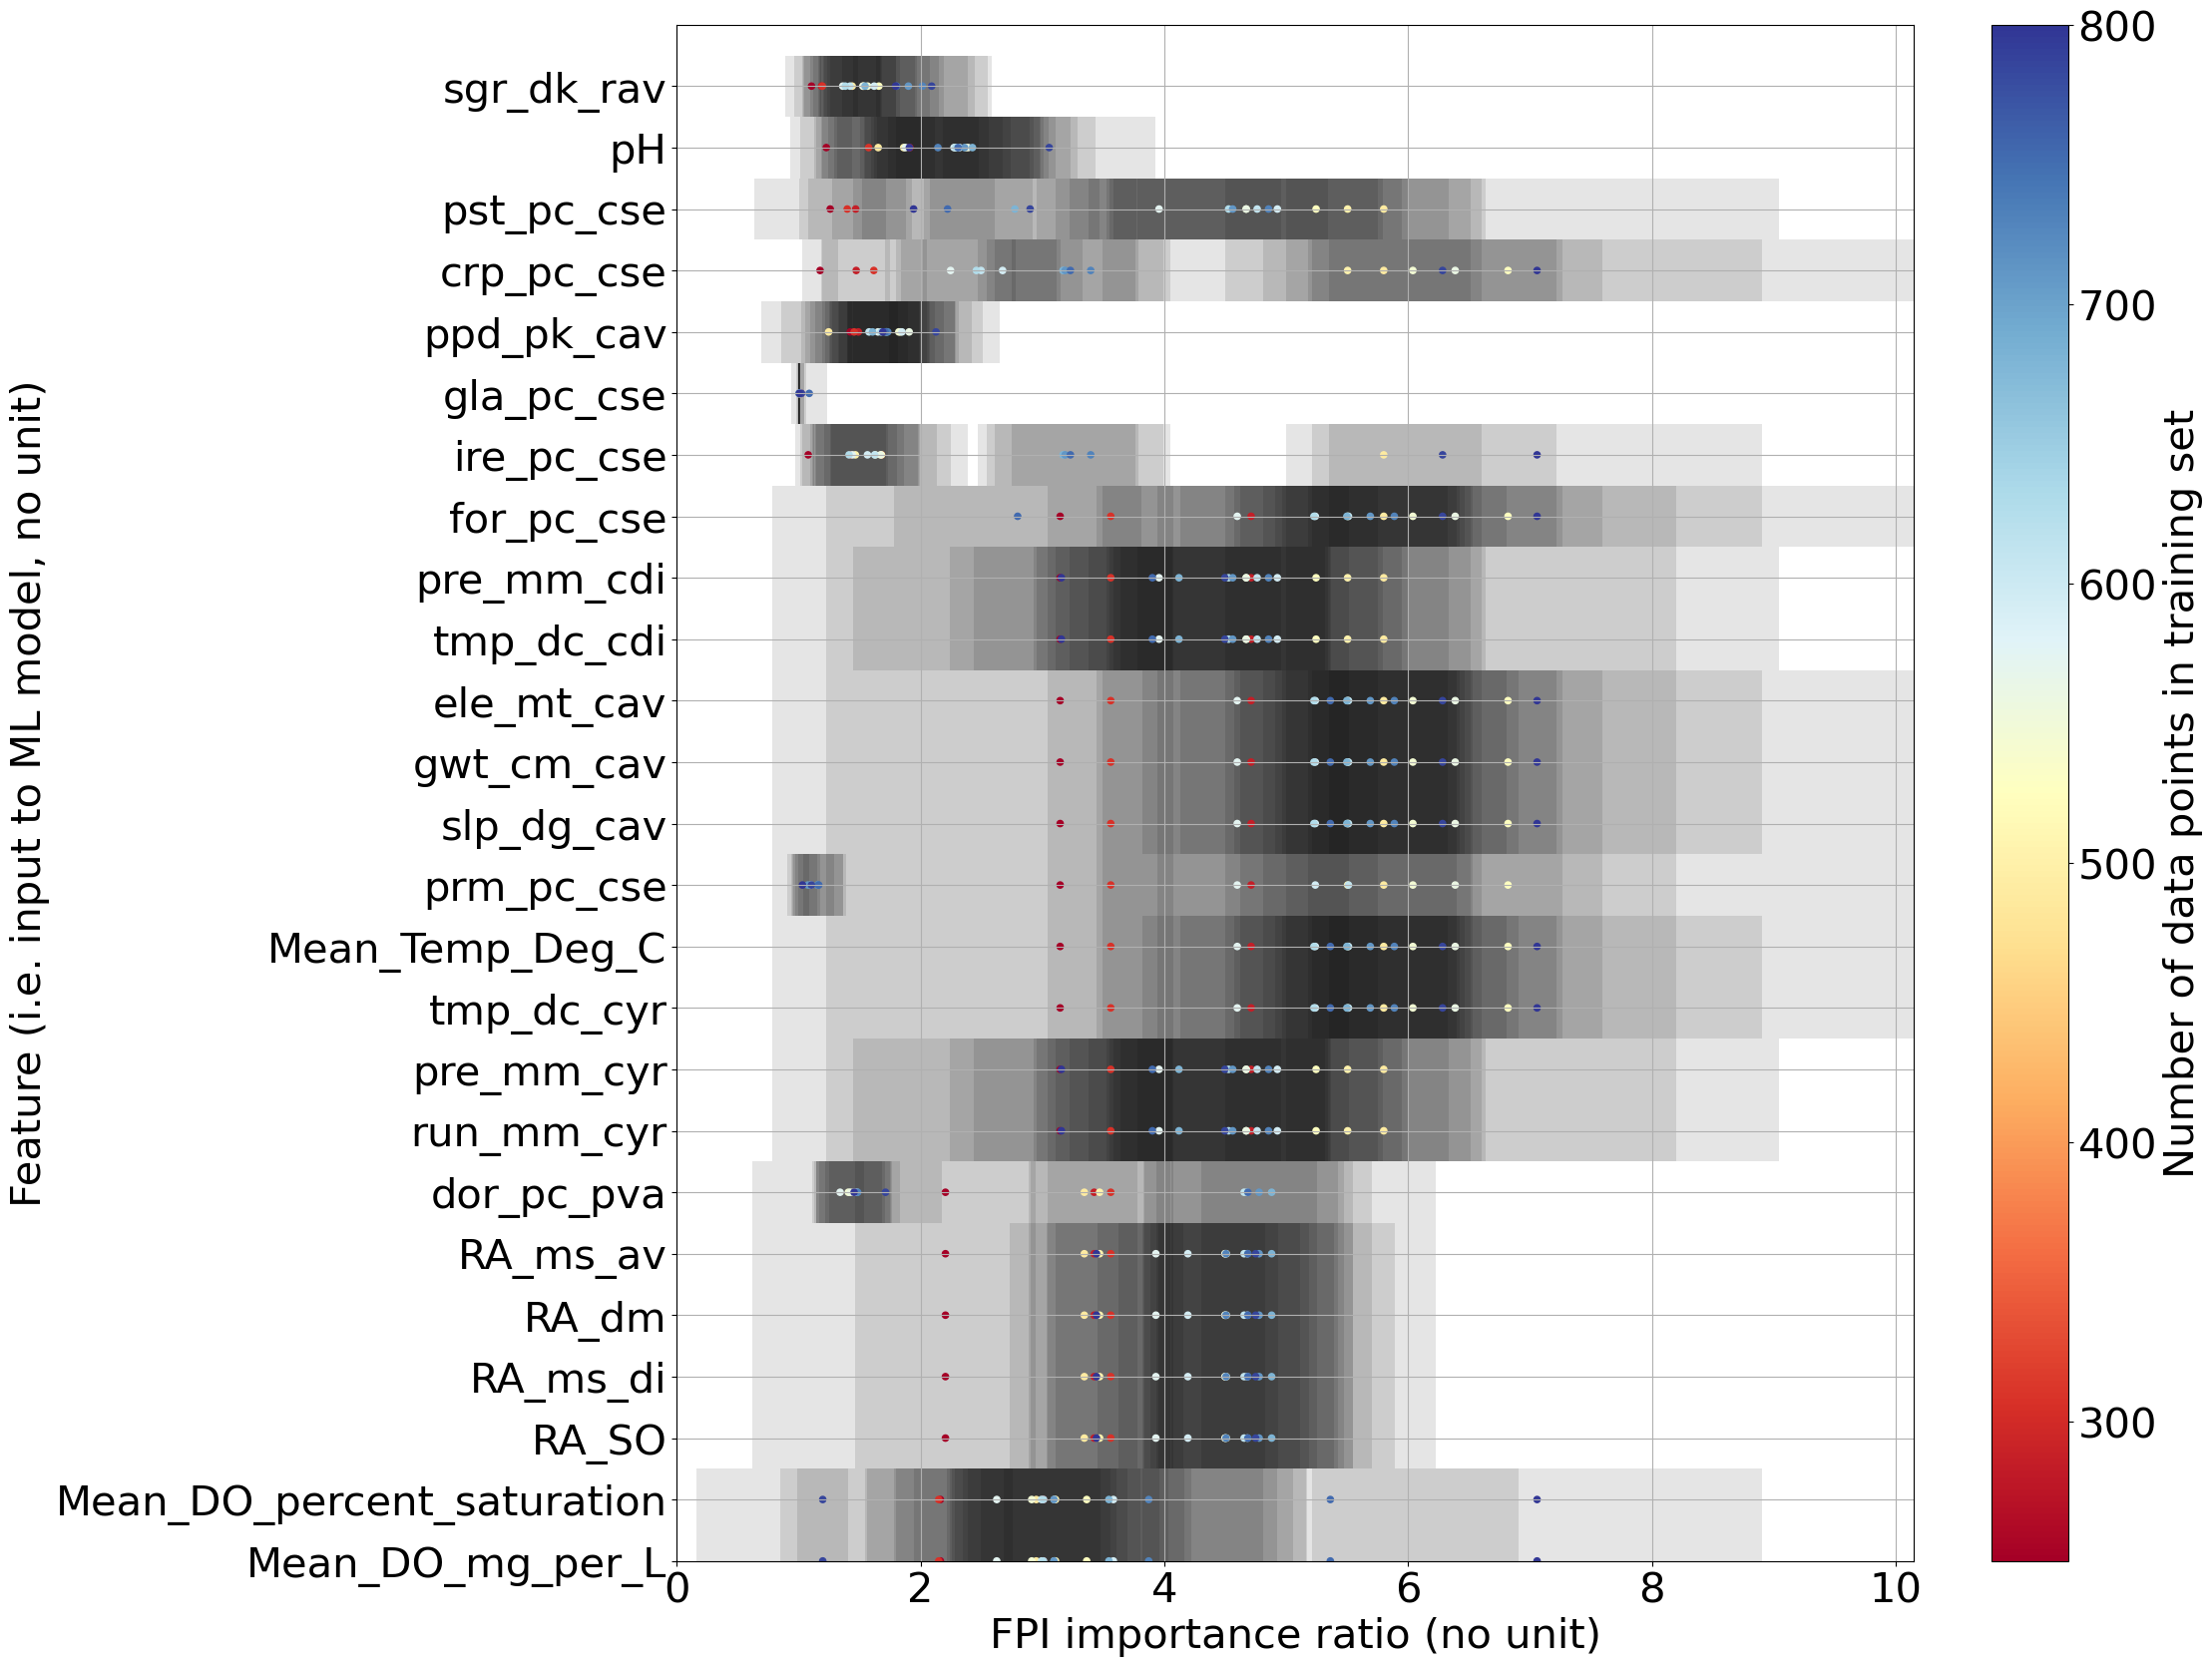

In [2]:
# Make a list of which branches to operate on.
# ASSUME that the first branch will have the most
# complete list of features (i.e. inputs) to the ML
# models. This first list of features will be
# used to create a look-up table for feature-to-feature
# comparisons/visulizations later.

list_branches = [
    'Summer-2019-log10',
    'Jul-2022-log10',
    'Aug-2022-log10',
    'Sep-2022-log10',
    'Oct-2022-log10',
    'Nov-2022-log10',
    'Dec-2022-log10',
    'Jan-2023-log10',
    'Feb-2023-log10',
    'Mar-2023-log10',
    'Apr-2023-log10',
    'May-2023-log10',
    'June-2023-log10',
    'Jul-2023-log10',
    'August-2023-log10',
    'Sep-2023-log10',
    'Oct-2023-log10',
    'Nov-2023-log10-DO-update-correct']

list_colors = ['k','r','g','b']
fpi_max = 0.0
alpha_overlay = 0.1

# Initialize empty dataframes
# for model scores and histograms
model_scores = pd.DataFrame(columns=['hold-out-avg','hold-out-std','ntrain'])
train_hist = pd.DataFrame(columns=list_branches)
predict_hist = pd.DataFrame(columns=list_branches)
test_hist = pd.DataFrame(columns=list_branches)

# Initialize empty list to overlay plot of means
scatter_id = []
scatter_mean = []
scatter_size = []
scatter_color = []

# Initialize a plot
fig, ax = plt.subplots(1,1,figsize=(20,20))
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(250, 800), cmap='RdYlBu'),
             ax=ax, orientation='vertical', label='Number of data points in training set')
#colormap = plt.cm.get_cmap('RdYlBu')

for ll,branch in enumerate(list_branches):
    
    # Check for first branch
    if ll == 0:
        print("On first branch; clone, checkout, and build feature integer ID lookup table...")
        ! mkdir -p {repo_prefix}
        ! cd {repo_prefix}; git clone {repo_url}
        ! cd {repo_prefix}/{repo_name}; git checkout {branch}
        
        # Load data for look up table only
        fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv', index_col=False)
        
        # Make the loop up table; need to invert
        # the keys (integers) with the values (feature names)
        # so that feature names can be converted to ints
        # later.
        feature_id_name_dict = dict((v,k) for k,v in fpi_avg['Unnamed: 0'].to_dict().items())
        
        # Unload the data b/c later we will want to use the index
        del fpi_avg
    else:
        # Set up is complete with first branch, just change to other branches
        ! cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # Load data and replace feature names with IDs in dict
    # In the process, get a list of features available in
    # just this branch.
    fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv', index_col=0)
    branch_feature_names = list(fpi_avg.index)
    fpi_avg.rename(index=feature_id_name_dict, inplace=True)
    
    fpi_std = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_std.csv', index_col=0)
    fpi_std.rename(index=feature_id_name_dict, inplace=True)
    
    # Get summary statistics over each FPI (random shuffle
    # of grouped features) iteration
    mean = fpi_avg.mean(axis=1)
    upper = fpi_avg.mean(axis=1)+fpi_avg.std(axis=1)
    lower = fpi_avg.mean(axis=1)-fpi_avg.std(axis=1)
    error = fpi_std.max(axis=1)
    
    # If the max value is bigger than the current value,
    # update it.
    if upper.max() > fpi_max:
        fpi_max = upper.max()
    
    # Load model scores
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    input_data = pd.read_csv(repo_prefix+repo_name+'/input_data/ICON-ModEx_Data.csv')
    
    model_scores.loc[len(model_scores.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index)
    ]
    
    # Grab histograms of the distribution of the target to
    # assess bias in the ML models
    train_all = pd.read_csv(repo_prefix+repo_name+'/input_data/ICON-ModEx_Data.csv')
    train_hist[branch] = train_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    
    # Need to grab predictions at observed sites at a deeper level
    # than the main output files; filter for only the observed sites.
    test_all = pd.read_csv(repo_prefix+repo_name+'/scripts/post_01_output_ml_predict_avg.csv',index_col='Sample_ID')
    test_all = test_all.filter(axis='index', regex="S19S|SSS|CM_")
    test_hist[branch] = test_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    
    predict_all = pd.read_csv(repo_prefix+repo_name+'/output_data/filtered_predict_output.csv')
    predict_hist[branch] = predict_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    
    # Plot a box for each feature. We work feature by feature
    # because not all features will be available and not all
    # are chopped out from the edges either; sometimes features
    # will be chopped out from the middle so we don't want to
    # plot continuous lines.
    
    # Also, print out good features:
    #print('Significant features for the ML model on this branch:')
    ff = 1
    for feature in branch_feature_names:
        # Get feature ID from the dict
        f_id = feature_id_name_dict[feature]
        
        # Get the center of the box
        f_mean = mean[f_id]
        
        # Get the upper and lower bounds of the box
        f_upper = upper[f_id] 
        f_lower = lower[f_id]
        f_error = error[f_id]
        
        # Rectangles with x=feature_id, y=fpi_score
        #left, bottom, width, height = (f_id - 0.5, f_lower, 1.0, f_upper-f_lower)
        
        # FLIPPED Rectangles with x=fpi_score, y=feature_id (can print feature name in figure)
        left, bottom, width, height = (f_lower, f_id - 0.5, f_upper-f_lower, 1.0)
        
        rect = plt.Rectangle((left, bottom), width, height,
            facecolor='k', alpha=alpha_overlay)
        
        # Add collection to axes
        ax.add_patch(rect)
        
        # Plot means
        # As black dots...
        #ax.plot(f_id,f_mean,'ko')
        # ...or as scatter color coded by number of samples
        # But don't do this here because gets overlaid by
        # translucent rectangles. So store data and plot
        # all at once later
        #ax.scatter(f_id,f_mean,10,len(input_data.index))
        scatter_id.append(f_id)
        scatter_mean.append(f_mean)
        scatter_size.append(20)
        scatter_color.append(len(input_data.index))
        
        # Print out feature name if it is a significant contribution
        # (Here, assume that "significant" means the lowest bound on
        # the FPI improvement ratio is above 1.0)
        if f_lower > 1.0:
            #print(str(ff)+" --- "+feature)
            ff = ff + 1
            
    # Clear loaded data
    del fpi_std
    del fpi_avg
    
# Done with looping over branches

# Scatter color plot the means
# Plot set up for x=fpi_score, y=feature_id
ax.scatter(scatter_mean,scatter_id,s=scatter_size,c=scatter_color,cmap=mpl.colormaps['RdYlBu'])

# Replace Feature ID on axis with feature names from the dict that stores all features over all branches
ax.set_yticks(np.arange(len(feature_id_name_dict.keys())), labels=feature_id_name_dict.keys())

ax.grid()

plt.ylim(0,len(feature_id_name_dict))
plt.xlim(0,fpi_max)

plt.ylabel('Feature (i.e. input to ML model, no unit)')
plt.xlabel('FPI importance ratio (no unit)')

plt.savefig('fig05-FPI-summary.pdf')

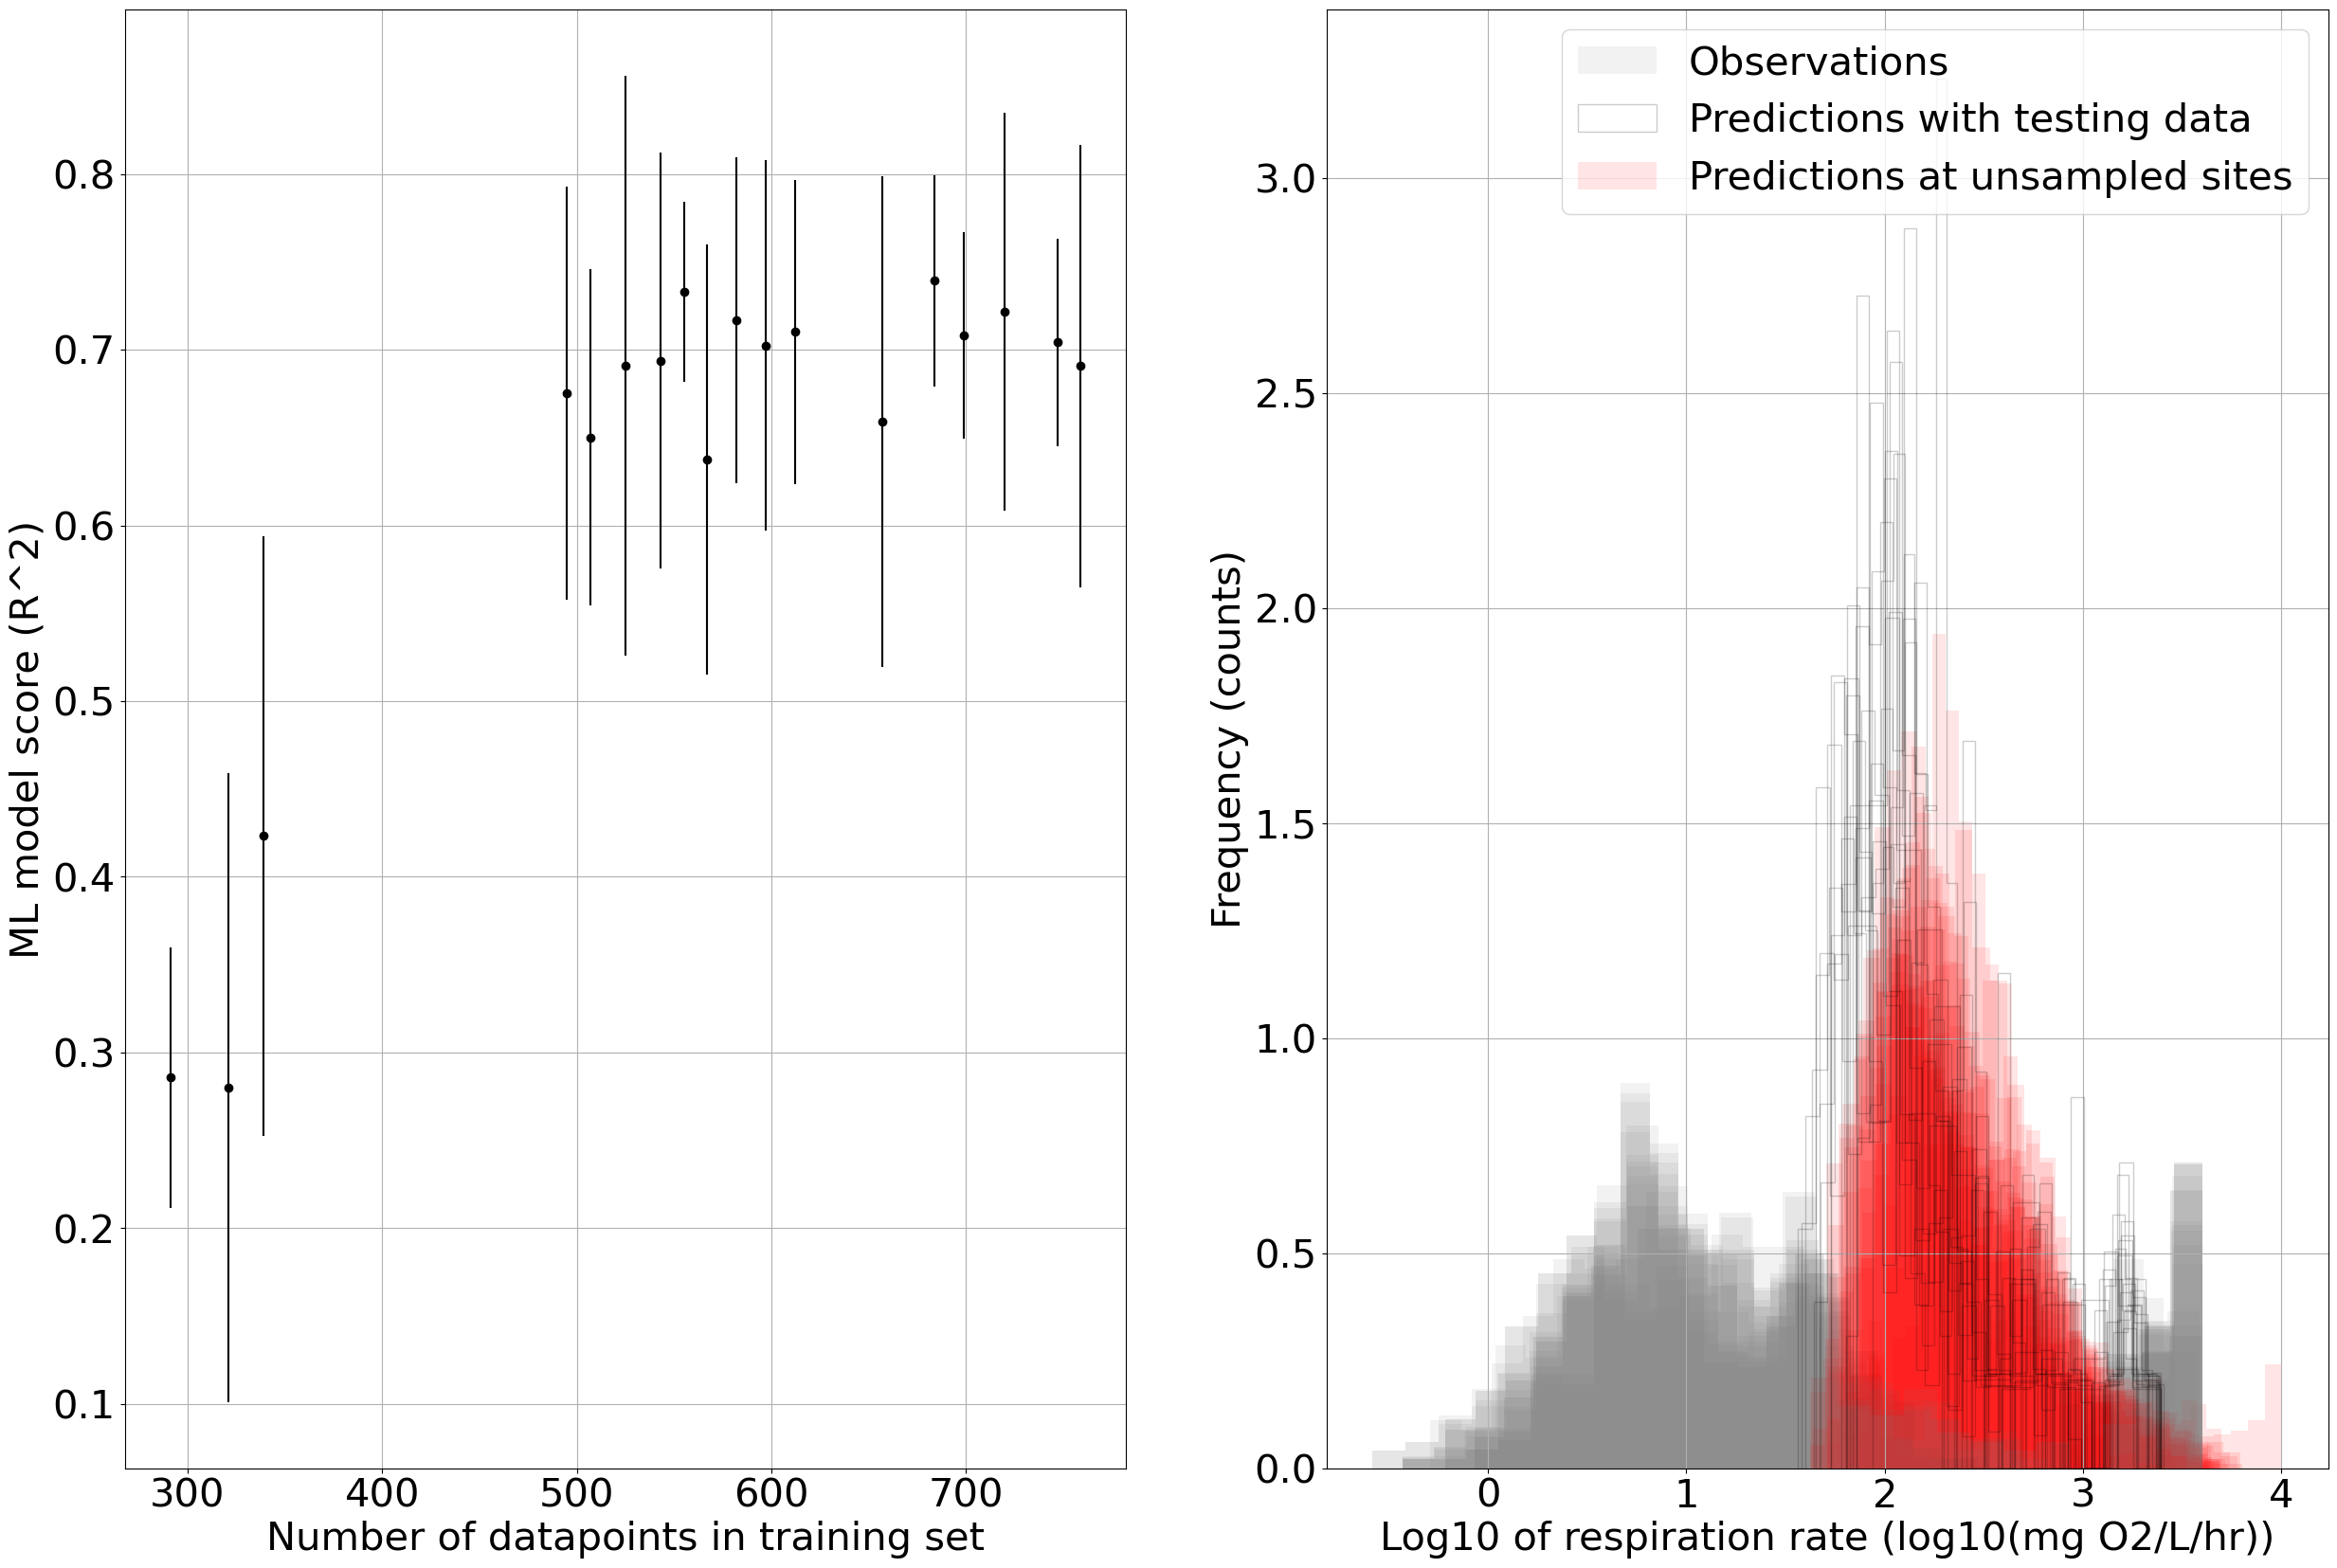

In [3]:
# Set up side-by-side plot
fig, (ax0, ax1)  = plt.subplots(1,2,figsize=(30,20))

# Plot progression of model score with training attempt
ax0.errorbar(model_scores['ntrain'], model_scores['hold-out-avg'],yerr=model_scores['hold-out-std'], fmt='ko')
ax0.grid()
ax0.set_xlabel('Number of datapoints in training set')
ax0.set_ylabel('ML model score (R^2)')

# Plot progression of histograms (for bias) with training attempt
nbin = 25
for bb,branch in enumerate(list_branches):
    # Histogram for training set truth reference
    n, bins, patches = ax1.hist(
            np.log10(np.abs(train_hist[branch])),
            nbin, density=True, histtype="stepfilled", linestyle=('dashed'), color=('gray'), alpha=0.1)
    
    # Histogram for predictions with test data
    n, bins, patches = ax1.hist(
            np.log10(np.abs(test_hist[branch])),
            nbin, density=True, histtype="step", linestyle=('solid'), color=('black'),alpha=0.2)
    
    # Histogram for predictions
    n, bins, patches = ax1.hist(
            np.log10(np.abs(predict_hist[branch])),
            nbin, density=True, histtype="stepfilled", linestyle=('solid'), color=('red'),alpha=0.1)
    
ax1.grid()
ax1.set_ylabel('Frequency (counts)')
ax1.set_xlabel('Log10 of respiration rate (log10(mg O2/L/hr))')

ax1.legend(['Observations','Predictions with testing data','Predictions at unsampled sites'])

## Tabulate FPI results

Given a repository and branch name, this notebook will tabulate the FPI results into a ranked list of the most important features, concatenate feature descriptions and data sources, and then save the result as a CSV file for uploading into a document for publication format.

In [4]:
# Selet one branch on the repo
table_branch_name = 'Nov-2023-log10-DO-update-correct'

# Load data
! cd {repo_prefix}/{repo_name}; git checkout {table_branch_name}
fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv',index_col=0)
fpi_std = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_std.csv',index_col=0)

Already on 'Nov-2023-log10-DO-update-correct'
Your branch is up to date with 'origin/Nov-2023-log10-DO-update-correct'.


### Load context dictionaries

Here we create some dictorionaries defining the variables. The variable descriptions are based on the `./WHONDRS_v3_CM_SSS_dd.csv` data dictionary (copied from the [source repository](https://data.ess-dive.lbl.gov/view/doi%3A10.15485%2F1923689)) and an manually transcribed data dictionary `./RiverAtlas_dd.csv` based on the [RiverAtlas data catalog](https://data.hydrosheds.org/file/technical-documentation/RiverATLAS_Catalog_v10.pdf) for RiverAtlas features.

Any feature not in these two data dictionaries will be classified as derived.

In [5]:
WHONDRS_features = pd.read_csv('WHONDRS_v3_CM_SSS_dd.csv',index_col=0)
RiverAtlas_features = pd.read_csv('RiverAtlas_dd.csv',index_col=0)

### Consolidate tables

In [6]:
# Initialize an empty dataframe to store the output table
FPI_summary = pd.DataFrame(columns=['ID','Importance','std(importance)','Uncertainty in importance','Source','Unit','Definition'],index=fpi_avg.index)

# Compute the mean, std, of the feature importance:
# Get summary statistics over each FPI (random shuffle
# of grouped features) iteration
mean = fpi_avg.mean(axis=1)
std = fpi_avg.std(axis=1)
uncert = fpi_std.max(axis=1)

# Loop over all features and gather information from data dictionaries
for feature in fpi_avg.index:
    
    # These values are set regardless of the data dictionary
    FPI_summary.loc[feature,'ID'] = feature_id_name_dict[feature]
    FPI_summary.loc[feature,'Importance'] = mean[feature]
    FPI_summary.loc[feature,'std(importance)'] = std[feature]
    FPI_summary.loc[feature,'Uncertainty in importance'] = uncert[feature]
    
    # Assign features based on data dictionary.  Need to relax the assignment
    # to allow for removing all _. and numbers from the variable names due to
    # slight inconsistencies with variable names here and in data dictionaries.
    if feature in WHONDRS_features.index:
        # Assign feature information from this data dictionary
        FPI_summary.loc[feature, 'Source'] = 'WHONDRS'
        FPI_summary.loc[feature, 'Unit'] = WHONDRS_features.loc[feature,'Unit']
        FPI_summary.loc[feature, 'Definition'] = WHONDRS_features.loc[feature,'Definition']
        
    elif feature in RiverAtlas_features.index:
        # Look in RiverAtlas
        FPI_summary.loc[feature, 'Source'] = 'RiverAtlas'
        FPI_summary.loc[feature, 'Unit'] = RiverAtlas_features.loc[feature,'Unit']
        FPI_summary.loc[feature, 'Definition'] = RiverAtlas_features.loc[feature,'Definition']
        
    else:
        # Insert defaults
        print('WARNING! Feature '+feature+' not found in data dictionaries! Fill values inserted.')
        FPI_summary.loc[feature, 'Source'] = 'Derived'
        FPI_summary.loc[feature, 'Units'] = 'UNKNOWN'
        FPI_summary.loc[feature, 'Definition'] = 'UNKNOWN'

In [7]:
# Sort and save data table
FPI_summary.sort_values(by='Importance',ascending=False).to_csv('FPI_summary_table_'+table_branch_name+'.csv')

In [8]:
FPI_summary.sort_values(by='Importance',ascending=False)

,ID,Importance,std(importance),Uncertainty in importance,Source,Unit,Definition
ele_mt_cav,14,7.058495,1.846157,10.86376,RiverAtlas,m,Mean elevation over reach catchment
Mean_Temp_Deg_C,10,7.058495,1.846157,10.86376,WHONDRS,degrees_Celsius,Mean water temperature from dissolved oxygen (...
for_pc_cse,17,7.058495,1.846157,10.86376,RiverAtlas,percent,Forest cover extent over reach catchment
crp_pc_cse,21,7.058495,1.846157,10.86376,RiverAtlas,percent,Cropland extent over reach catchment
Mean_DO_mg_per_L,0,7.058495,1.846157,10.86376,WHONDRS,milligrams_per_liter,Dissolved oxygen measured during in situ senso...
Mean_DO_percent_saturation,1,7.058495,1.846157,10.86376,WHONDRS,percent_saturation,Dissolved oxygen saturation measured during in...
gwt_cm_cav,13,7.058495,1.846157,10.86376,RiverAtlas,cm,Mean ground water table depth over reach catch...
slp_dg_cav,12,7.058495,1.846157,10.86376,RiverAtlas,degx10,Mean terrain slope over reach catchment
ire_pc_cse,18,7.058495,1.846157,10.86376,RiverAtlas,percent,Irrigated area extent (Equipped) over reach ca...
tmp_dc_cyr,9,7.058495,1.846157,10.86376,RiverAtlas,deg. C,Annual avg. air temp. over reach catchment
